# Постановка задачи для анализа данных

Тема: Разработка алгоритма определения породы собаки по фото

Мы использовали tensorflow и sklearn.

Вся работа была проделана по шаблону CRISP-DM. Работа включает в себя постановку задачи для анализа данных, сбор/подбор данных, проведение исследования данных, моделирование и оценку результатов.



# Сбор данных

Мы выбрали данные с kaggle:
https://www.kaggle.com/datasets/jessicali9530/stanford-dogs-dataset

Они связаны с различными породами собак

In [ ]:
!pip install kaggle

In [ ]:
import os
import shutil
# Для работы с kaggle
os.makedirs('~/.kaggle', exist_ok=True)
shutil.move('kaggle.json', '~/.kaggle/kaggle.json')
os.chmod('~/.kaggle/kaggle.json', 0o600)

In [ ]:
!kaggle datasets download -d jessicali9530/stanford-dogs-dataset

Dataset URL: https://www.kaggle.com/datasets/jessicali9530/stanford-dogs-dataset
License(s): other
 99% 741M/750M [00:06<00:00, 102MB/s]
100% 750M/750M [00:06<00:00, 116MB/s]


In [ ]:
import zipfile
zip_filename = 'stanford-dogs-dataset.zip'
os.makedirs('new', exist_ok=True)
with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
    zip_ref.extractall('new')

In [ ]:
print(os.listdir('new'))

['annotations', 'images']


In [ ]:
import os
import shutil
import random

images_dir = 'new/images/Images'
annotations_dir = 'new/annotations/Annotation'

annotation_categories = os.listdir(annotations_dir)
image_categories = os.listdir(images_dir)

if annotation_categories != image_categories:
    raise ValueError("Количество категорий в аннотациях и изображениях не совпадает!")

train_path = '/content/train'
test_path = '/content/test'
os.makedirs(train_path, exist_ok=True)
os.makedirs(test_path, exist_ok=True)

test_size = 0.1


for category in annotation_categories:
    # Создание подкаталогов для каждой категории
    os.makedirs(os.path.join(train_path, category), exist_ok=True)
    os.makedirs(os.path.join(test_path, category), exist_ok=True)

    # Получение всех файлов аннотаций и изображений для данной категории
    annotation_files = os.listdir(os.path.join(annotations_dir, category))
    image_files = os.listdir(os.path.join(images_dir, category))

    if len(annotation_files) != len(image_files):
        raise ValueError(f"Количество файлов аннотаций и изображений не совпадает для категории: {category}")

    # Разделение на train и test
    combined = list(zip(annotation_files, image_files))
    random.shuffle(combined)

    split_index = int(len(combined) * (1 - test_size))
    train_files, test_files = combined[:split_index], combined[split_index:]

    for annotation, image in train_files:
        shutil.copy(os.path.join(annotations_dir, category, annotation),
                    os.path.join(train_path, category, annotation))
        shutil.copy(os.path.join(images_dir, category, image),
                    os.path.join(train_path, category, image))

    for annotation, image in test_files:
        shutil.copy(os.path.join(annotations_dir, category, annotation),
                    os.path.join(test_path, category, annotation))
        shutil.copy(os.path.join(images_dir, category, image),
                    os.path.join(test_path, category, image))

print("Данные успешно подготовлены!")

Данные успешно подготовлены!


In [ ]:
import os
import glob
import matplotlib.pyplot as plt
import numpy as np

train_path = 'train'
test_path = 'test'

# Функция для подготовки данных
def load_data(data_path):
    X, y = [], []
    categories = os.listdir(data_path)
    valid_extensions = ('*.jpg', '*.jpeg', '*.png', '*.bmp', '*.gif')
    for category in categories:
        category_path = os.path.join(data_path, category)
        for extension in valid_extensions:
            image_files = glob.glob(os.path.join(category_path, extension))
            X.extend(image_files)
            y.extend([category] * len(image_files))
    return np.array(X), np.array(y)

# Загрузка данных
X_train, y_train = load_data(train_path)
X_test, y_test = load_data(test_path)

# Функция для отображения изображений и их категорий
def display_images(X, y, num_images=5):
  try:
      indices = np.random.choice(len(X), num_images, replace=False)
      plt.figure(figsize=(15, 5))
      for i, idx in enumerate(indices):
          img = plt.imread(X[idx])
          plt.subplot(1, num_images, i + 1)
          plt.imshow(img)
          plt.title(y[idx][10:])
          plt.axis('off')
  except Exception as e:
      print(f"Ошибка: {e}")
      plt.show()

Примеры изображений из train набора:


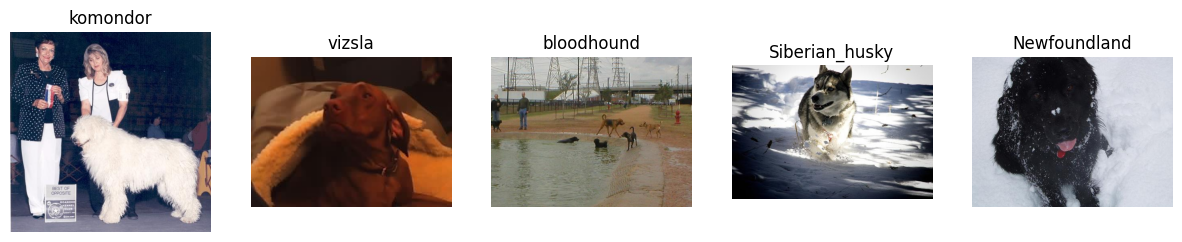

In [ ]:
print("Примеры изображений из train набора:")
display_images(X_train, y_train)

Примеры изображений из test набора:


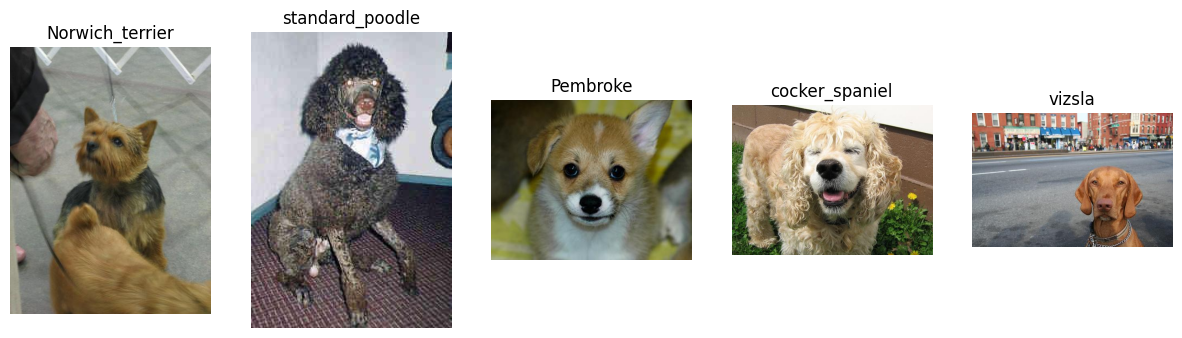

In [ ]:
print("Примеры изображений из test набора:")
display_images(X_test, y_test)


Таким образом, собраны необходимые для дальнейшей работы данные и частично подготовлены к работе

# Исследование данных

In [ ]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (20482,)
y_train shape: (20482,)
X_test shape: (10655,)
y_test shape: (10655,)


In [ ]:
y_train

array(['n02106030-collie', 'n02106030-collie', 'n02106030-collie', ...,
       'n02086910-papillon', 'n02086910-papillon', 'n02086910-papillon'],
      dtype='<U40')

In [ ]:
X_train

array(['train/n02106030-collie/n02106030_18516.jpg',
       'train/n02106030-collie/n02106030_19483.jpg',
       'train/n02106030-collie/n02106030_7572.jpg', ...,
       'train/n02086910-papillon/n02086910_7156.jpg',
       'train/n02086910-papillon/n02086910_4790.jpg',
       'train/n02086910-papillon/n02086910_2240.jpg'], dtype='<U66')

In [ ]:
y_test

array(['n02106030-collie', 'n02106030-collie', 'n02106030-collie', ...,
       'n02086910-papillon', 'n02086910-papillon', 'n02086910-papillon'],
      dtype='<U40')

In [ ]:
X_test

array(['test/n02106030-collie/n02106030_17923.jpg',
       'test/n02106030-collie/n02106030_7895.jpg',
       'test/n02106030-collie/n02106030_14653.jpg', ...,
       'test/n02086910-papillon/n02086910_2380.jpg',
       'test/n02086910-papillon/n02086910_5010.jpg',
       'test/n02086910-papillon/n02086910_1957.jpg'], dtype='<U65')

In [ ]:
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import cv2

# Преобразование меток категорий в числа
label_encoder = LabelEncoder()
y_train= label_encoder.fit_transform(y_train)
y_test = label_encoder.fit_transform(y_test)

# Функция для загрузки изображений и изменения их размера
def load_and_preprocess_images(image_paths, target_size=(128, 128)):
       images = []
       for img_path in image_paths:
           img = cv2.imread(img_path)
           if img is not None:
               img = cv2.resize(img, target_size)
               images.append(img)
           else:
               print(f"Error loading image {img_path}")
       return np.array(images)

# Загрузка и предварительная обработка изображений
X_train = load_and_preprocess_images(X_train)
X_test = load_and_preprocess_images(X_test)


In [ ]:
X_train

array([[[[105, 112, 121],
         [106, 112, 122],
         [111, 118, 127],
         ...,
         [214, 200, 207],
         [232, 214, 218],
         [243, 226, 232]],

        [[124, 129, 135],
         [122, 127, 133],
         [118, 123, 129],
         ...,
         [205, 193, 200],
         [253, 237, 239],
         [236, 222, 227]],

        [[131, 133, 135],
         [131, 134, 135],
         [132, 134, 136],
         ...,
         [187, 178, 185],
         [250, 237, 239],
         [222, 210, 215]],

        ...,

        [[113, 111, 110],
         [127, 125, 124],
         [123, 122, 121],
         ...,
         [127, 126, 128],
         [134, 133, 135],
         [137, 136, 138]],

        [[128, 126, 125],
         [123, 121, 120],
         [123, 122, 121],
         ...,
         [126, 125, 127],
         [140, 139, 141],
         [123, 122, 124]],

        [[127, 126, 127],
         [128, 124, 117],
         [138, 139, 136],
         ...,
         [128, 127, 129],
        

In [ ]:
X_test

array([[[[236, 225, 175],
         [234, 223, 173],
         [236, 225, 175],
         ...,
         [228, 215, 137],
         [225, 212, 134],
         [228, 216, 128]],

        [[227, 217, 167],
         [227, 218, 167],
         [228, 218, 169],
         ...,
         [232, 218, 139],
         [227, 212, 133],
         [227, 216, 133]],

        [[226, 216, 168],
         [227, 217, 169],
         [229, 219, 171],
         ...,
         [239, 224, 145],
         [241, 226, 147],
         [231, 222, 143]],

        ...,

        [[243, 230, 156],
         [243, 230, 156],
         [242, 229, 155],
         ...,
         [201, 198, 129],
         [195, 194, 124],
         [187, 187, 121]],

        [[242, 229, 155],
         [242, 229, 155],
         [243, 230, 156],
         ...,
         [199, 194, 131],
         [195, 194, 126],
         [193, 185, 125]],

        [[242, 229, 155],
         [242, 229, 155],
         [241, 228, 154],
         ...,
         [204, 199, 136],
        

In [ ]:
y_test

array([80, 80, 80, ...,  6,  6,  6])

In [ ]:
y_train

array([80, 80, 80, ...,  6,  6,  6])

Таким образом, данные обработаны и приведены к нужному формату.

# Моделирование


In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(len(np.unique(y_train)), activation='softmax')
])

# Компиляция модели
model.compile(optimizer='nadam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Обучение модели
history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=10,
                    batch_size=64)

# Оценка модели на тестовых данных
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print("Test accuracy:", test_accuracy)

Epoch 1/10
309/309 ━━━━━━━━━━━━━━━━━━━━ 774s 3s/step - accuracy: 0.2861 - loss: 3.2912 - val_accuracy: 0.3894 - val_loss: 2.9770
Epoch 2/10
309/309 ━━━━━━━━━━━━━━━━━━━━ 797s 2s/step - accuracy: 0.4294 - loss: 2.5333 - val_accuracy: 0.5234 - val_loss: 2.4582
Epoch 3/10
309/309 ━━━━━━━━━━━━━━━━━━━━ 845s 3s/step - accuracy: 0.5569 - loss: 1.9474 - val_accuracy: 0.5990 - val_loss: 2.2272
Epoch 4/10
309/309 ━━━━━━━━━━━━━━━━━━━━ 861s 3s/step - accuracy: 0.6428 - loss: 1.5679 - val_accuracy: 0.6473 - val_loss: 2.0783
Epoch 5/10
309/309 ━━━━━━━━━━━━━━━━━━━━ 810s 2s/step - accuracy: 0.7089 - loss: 1.2641 - val_accuracy: 0.7109 - val_loss: 2.0352
Epoch 6/10
309/309 ━━━━━━━━━━━━━━━━━━━━ 800s 2s/step - accuracy: 0.7554 - loss: 1.0418 - val_accuracy: 0.7341 - val_loss: 2.0447
Epoch 7/10
309/309 ━━━━━━━━━━━━━━━━━━━━ 754s 2s/step - accuracy: 0.7904 - loss: 0.9333 - val_accuracy: 0.7402 - val_loss: 2.0804
Epoch 8/10
309/309 ━━━━━━━━━━━━━━━━━━━━ 806s 2s/step - accuracy: 0.8123 - loss: 0.8125 - val_accu

Модель показала неплохие значения: accuracy = 0,8554 и val_accuracy = 0,8020

Попробуем улучшить их, используя DropOut.

Dropout - техника спасения нейросетей от переобучения, при которой в процессе тренировки случайно "выключаются" некоторые нейроны из моделей.

In [ ]:
model1 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(0.25), #Dropout
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(len(np.unique(y_train)), activation='softmax')
])

# Компиляция модели
model1.compile(optimizer='nadam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
history1 = model1.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=10,
                    batch_size=64)

Epoch 1/10
322/322 ━━━━━━━━━━━━━━━━━━━━ 838s 3s/step - accuracy: 0.0139 - loss: 10.0237 - val_accuracy: 0.0530 - val_loss: 4.4949
Epoch 2/10
322/322 ━━━━━━━━━━━━━━━━━━━━ 858s 3s/step - accuracy: 0.0480 - loss: 4.4979 - val_accuracy: 0.0992 - val_loss: 4.1609
Epoch 3/10
322/322 ━━━━━━━━━━━━━━━━━━━━ 821s 3s/step - accuracy: 0.1007 - loss: 4.0650 - val_accuracy: 0.2436 - val_loss: 3.4589
Epoch 4/10
322/322 ━━━━━━━━━━━━━━━━━━━━ 813s 3s/step - accuracy: 0.2101 - loss: 3.4622 - val_accuracy: 0.4006 - val_loss: 2.6863
Epoch 5/10
322/322 ━━━━━━━━━━━━━━━━━━━━ 861s 3s/step - accuracy: 0.3608 - loss: 2.7020 - val_accuracy: 0.5713 - val_loss: 1.9457
Epoch 6/10
322/322 ━━━━━━━━━━━━━━━━━━━━ 898s 3s/step - accuracy: 0.4977 - loss: 2.0539 - val_accuracy: 0.6619 - val_loss: 1.4471
Epoch 7/10
322/322 ━━━━━━━━━━━━━━━━━━━━ 830s 3s/step - accuracy: 0.6161 - loss: 1.5329 - val_accuracy: 0.8060 - val_loss: 0.9166
Epoch 8/10
322/322 ━━━━━━━━━━━━━━━━━━━━ 860s 3s/step - accuracy: 0.7181 - loss: 1.1337 - val_acc

Значение стали выше и "плавнее". Мы считаем это хорошим результатом обучения.

accuracy: 0.8096

val_accuracy: 0.9330

Попробуем применить аугментацию(увелечение числа картинок без привлечения новых картинок)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
datagen = ImageDataGenerator(horizontal_flip=True, vertical_flip=True)

In [ ]:
train_generator = datagen.flow(X_train, y_train, batch_size=128)

In [ ]:
model_gen= tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(0.25), #Dropout
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(len(np.unique(y_train)), activation='softmax')
])

# Компиляция модели
model_gen.compile(optimizer='nadam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
gen_model = model_gen.fit(train_generator,
                        epochs=10,
                        validation_data=(X_test, y_test))

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


145/145 ━━━━━━━━━━━━━━━━━━━━ 726s 5s/step - accuracy: 0.0090 - loss: 22.5111 - val_accuracy: 0.0166 - val_loss: 4.7423
Epoch 2/10
145/145 ━━━━━━━━━━━━━━━━━━━━ 754s 5s/step - accuracy: 0.0187 - loss: 4.7460 - val_accuracy: 0.0218 - val_loss: 4.7067
Epoch 3/10
145/145 ━━━━━━━━━━━━━━━━━━━━ 744s 5s/step - accuracy: 0.0257 - loss: 4.6933 - val_accuracy: 0.0213 - val_loss: 4.7077
Epoch 4/10
145/145 ━━━━━━━━━━━━━━━━━━━━ 749s 5s/step - accuracy: 0.0292 - loss: 4.6162 - val_accuracy: 0.0161 - val_loss: 4.6668
Epoch 5/10
145/145 ━━━━━━━━━━━━━━━━━━━━ 770s 5s/step - accuracy: 0.0401 - loss: 4.5269 - val_accuracy: 0.0303 - val_loss: 4.5882
Epoch 6/10
145/145 ━━━━━━━━━━━━━━━━━━━━ 740s 5s/step - accuracy: 0.0524 - loss: 4.4474 - val_accuracy: 0.0299 - val_loss: 4.5361
Epoch 7/10
145/145 ━━━━━━━━━━━━━━━━━━━━ 757s 5s/step - accuracy: 0.0701 - loss: 4.3338 - val_accuracy: 0.0384 - val_loss: 4.5171
Epoch 8/10
145/145 ━━━━━━━━━━━━━━━━━━━━ 750s 5s/step - accuracy: 0.0800 - loss: 4.2428 - val_accuracy: 0.03

Значения стали намного хуже

# Оценка результатов

Построим графики значений Val_accuracy и accuracy для моделей.

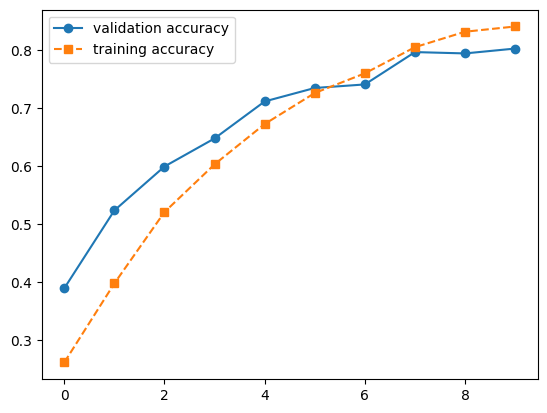

In [ ]:
plt.plot(history.history['val_accuracy'], '-o', label='validation accuracy')
plt.plot(history.history['accuracy'], '--s', label='training accuracy')
plt.legend();

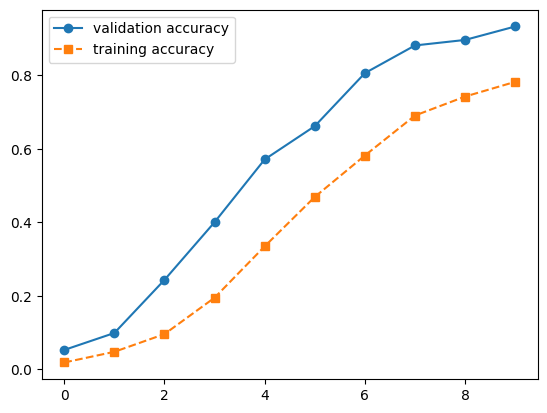

In [ ]:
plt.plot(history1.history['val_accuracy'], '-o', label='validation accuracy')
plt.plot(history1.history['accuracy'], '--s', label='training accuracy')
plt.legend();

Значения лучше и плавнее во втором случае (с применением Dropout).

Итого это наилучший полученный результат:

accuracy: 0.8096

val_accuracy: 0.9330